# Which measurements are informative on patients' ICU outcomes?

In [1]:
# Generic imports
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
# Custom import
sys.path.append('../src/')
from Thomas_code import patients, feature_conversion
import flm_tools

The main goal during my masters thesis research was to reduce the number of clinical measurements that would be used in a model of patient trajectories in the ICU. My first approach was to search for measurements that would associate with how favorable the discharge disposition was.  
In that vein, I asked two initial questions:  
1. For numeric measurements (which are the majority), which ones would associate with the favorability of the discharge disposition when looking at their typical visit value?  
2. Knowing that this dataset isn't a random sample of tests, and that doctors are likely following clinical suspicions, which clinical measurements would associate with the favorability of the discharge disposition simply by their presence/absence?

## First, get the data

Let's obtain the main table for this notebook. The first line implements a series of data reading and wrangling procedures that became repetitive throughout my masters. As such, they were all wrapped into this neat line of code.

In [4]:
clean_all_table = flm_tools.get_cleaned_data(version='2021-06-02/210602_digest_including_basic_endpoints_and_sofa')

# At the time, we knew of only a handful of issues regarding units
# This is the one-liner that dealt with those.
clean_all_table = flm_tools.convert_to_standard_units(clean_all_table)

# Adding day of stay column to avoid using dates
clean_all_table = flm_tools.add_column_with_day_of_stay(clean_all_table)

I decided to restrict analysis to patients for which we had adjudication of the pneumonia type (hospital-acquired (HAP), community-acquired (CAP), or ventilator-acquired (VAP) pneumonia). If not, patients were excluded. This decision is unique to this analysis, so I did not place this block within a function.

In [5]:
diagnosis = patients.modified_edw_rc('pneumonia_episode_category_assessment',
                                     revision='2021-06-02/210602_digest_including_basic_endpoints_and_sofa',
                                     columns=['case_number',
                                              'clin_cap_viral_npop',
                                              'pneu_assess_dt',
                                              'pt_category'])

# Shortening the pneumonia category string
diagnosis = feature_conversion.shorten_pt_category(diagnosis)

# Gotta have the category assessed!
diagnosis = diagnosis.dropna(subset=['pt_category'])

# We chose to group HAP and VAP
diagnosis['pt_category'] = diagnosis['pt_category'].replace({'VAP': 'HAP/VAP',
                                                            'HAP': 'HAP/VAP'})

# Patients can transition from one category to another during ICU stay
# However, it always went towards HAP or VAP (which is why we grouped them)
diagnosis = diagnosis.drop_duplicates(subset=['case_number'], keep='last')

clean_all_table = pd.merge(clean_all_table, diagnosis)

In [6]:
# Outputting some general numbers
total_unique_tests = clean_all_table['measurement_concept_name'].nunique()
print(f"These are the number of unique clinical measurements present: {total_unique_tests}")
total_cases = clean_all_table['case_number'].nunique()
print(f"Number of cases/patients with available records and outcomes: {total_cases}")

These are the number of unique clinical measurements present: 541
Number of cases/patients with available records and outcomes: 307


## Question 1: Does the typical value of a numeric clinical test during a patient's hospitalization predict the patient's discharge favorability?  
For each patient and each clinical measurement/test, I determined the typical value using the median and the mean, and used Spearman's rank correlation to measure association of the typical values of a test with the discharge favorability or discharge rank\*. I chose Spearman's correlation rather than Pearson's because it **non-parametrically** quantifies monotonic associations. Also, non-parametric methods have lower false positive rates (i.e. the reject-null-hypothesis rate is lower), which can give more confidence in the robustness of the results (it also demands more of the data).  
  
  \**Intensive-care physicians had previously ranked discharges from 0 to 5, to capture how favorable they were. Zero was expired, five was discharged home.*

In [7]:
# Extracting the strictly numerical tests in the data and cleaning up
a = clean_all_table['value_as_number'].notnull()
num_measure_table = clean_all_table[a]

# Some numerical tests come with ranges (>, <, >=, <=). Deleting those entries.
b = num_measure_table['operator_vocabulary_id'] != 'SNOMED'
num_measure_table = num_measure_table.loc[b].copy()

In [8]:
# Obtaining median value
median_values = num_measure_table.groupby(
    ['case_number',
     'discharge_disposition_multiple',
     'measurement_concept_code',
     'measurement_concept_name'])['value_as_number'].median().to_frame('median_value').reset_index()

# Obtaining mean value
mean_values = num_measure_table.groupby(
    ['case_number',
     'discharge_disposition_multiple',
     'measurement_concept_code',
     'measurement_concept_name'])['value_as_number'].mean().to_frame('mean_value').reset_index()


# These lines is take away measurements appearing only once on both pandas dataframes
c = median_values['measurement_concept_name'].value_counts()
median_values = median_values[median_values['measurement_concept_name'].isin(c[c>1].index)]

d = mean_values['measurement_concept_name'].value_counts()
mean_values = mean_values[mean_values['measurement_concept_name'].isin(d[d>1].index)]


# Making the measurements the row indices.
median_values = median_values.set_index('measurement_concept_name')
mean_values = mean_values.set_index('measurement_concept_name')

Implementing Spearman's rank correlation for table with median values

In [9]:
from scipy.stats import spearmanr
agg_results = []

# Running Spearman on every test separately
for test in median_values.index.unique():
    discharges = median_values.loc[test, 'discharge_disposition_multiple']
    measurement_values = median_values.loc[test, 'median_value']
    
    rho, pvalue = spearmanr(discharges, measurement_values)
    
    result_summary = {'measurement_name': test,
                      'Corr_values_Spearman': rho,
                      'P_values_Spearman': pvalue,
                      # Implementing Bonferroni correction since there multiple comparisons
                      'Bonferroni_pvalue': np.clip([pvalue*median_values.index.nunique()],
                                                   0,
                                                   1)[0],
                      '#_cases_given_test': len(discharges)}
    
    agg_results.append(result_summary)
    
results = pd.DataFrame(agg_results)
results['%_cases_given_test'] = (results['#_cases_given_test']/total_cases)*100

# Taking away tests without a valid p-value
results_median = results.dropna(subset=['Corr_values_Spearman',
                                        'P_values_Spearman',
                                        'Bonferroni_pvalue']).copy()

# Some tests end up with p-value=0. Dealing with those for log-Bonferroni
e = results_median['Bonferroni_pvalue'] == 0.0
results_median.loc[e, 'log_bonferroni'] = np.inf
results_median.loc[~e,
                   'log_bonferroni'] = -1*np.log10(results_median.loc[~e,
                                                                      'Bonferroni_pvalue'])

C:\Users\FLM9508\.conda\envs\sam\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Now repeating the above procedure for table with mean values

In [10]:
agg_results = []

# Running Spearman on every test separately
for test in mean_values.index.unique():
    discharges = mean_values.loc[test, 'discharge_disposition_multiple']
    measurement_values = mean_values.loc[test, 'mean_value']
    
    rho, pvalue = spearmanr(discharges, measurement_values)
    
    result_summary = {'measurement_name': test,
                      'Corr_values_Spearman': rho,
                      'P_values_Spearman': pvalue,
                      # Implementing Bonferroni correction since there multiple comparisons
                      'Bonferroni_pvalue': np.clip([pvalue*mean_values.index.nunique()],
                                                   0,
                                                   1)[0],
                      '#_cases_given_test': len(discharges)}
    
    agg_results.append(result_summary)
    
results = pd.DataFrame(agg_results)
results['%_cases_given_test'] = (results['#_cases_given_test']/total_cases)*100

# Taking away tests without a valid p-value
results_mean = results.dropna(subset=['Corr_values_Spearman',
                                      'P_values_Spearman',
                                      'Bonferroni_pvalue']).copy()

# Some tests end up with p-value=0. Dealing with those for log-Bonferroni
f = results_mean['Bonferroni_pvalue'] == 0.0
results_mean.loc[f, 'log_bonferroni'] = np.inf
results_mean.loc[~f,
                 'log_bonferroni'] = -1*np.log10(results_mean.loc[~f,
                                                                  'Bonferroni_pvalue'])

Modifying both the median and mean result tables a bit for downstream plotting

In [11]:
# Median
results_median_sig = results_median[results_median.Bonferroni_pvalue < 0.01].copy()
results_median_nonsig = results_median[results_median.Bonferroni_pvalue >= 0.01].copy()
g = results_median_sig['P_values_Spearman'] != 0.0
results_median_sig = results_median_sig.loc[g].copy()

In [12]:
for_annot_median = results_median_sig[results_median_sig.Bonferroni_pvalue < 0.000001]
x_median = list(for_annot_median['Corr_values_Spearman'])
y_median = list(for_annot_median['log_bonferroni'])
text_median = ['Glucose in:\nserum\nurine\nvenous blood',
               'Hematocrit/Serum protein',
               'Glucose in:\nserum\nurine\nvenous blood',
               'Hematocrit/Serum protein',
               'Glucose in:\nserum\nurine\nvenous blood',
               'Lymphocytes/100 leukocytes',
               'Neutrophils/100 leukocytes',
               'Red blood cell count']

In [13]:
# Mean
results_mean_sig = results_mean[results_mean.Bonferroni_pvalue < 0.01]
results_mean_nonsig = results_mean[results_mean.Bonferroni_pvalue >= 0.01]
h = results_mean_sig['P_values_Spearman'] != 0.0
results_mean_sig = results_mean_sig.loc[h]

In [14]:
for_annot_mean = results_mean_sig[results_mean_sig.Bonferroni_pvalue < 0.000001]
x_mean = list(for_annot_mean['Corr_values_Spearman'])
y_mean = list(for_annot_mean['log_bonferroni'])
text_mean = ['Glucose in:\nserum\nurine\nvenous blood',
             'Serum protein',
             'Glucose in:\nserum\nurine\nvenous blood',
             'Hematocrit',
             'Glucose in:\nserum\nurine\nvenous blood',
             'Lymphocytes/100 leukocytes',
             'Neutrophils/100 leukocytes']

Now comes the plotting

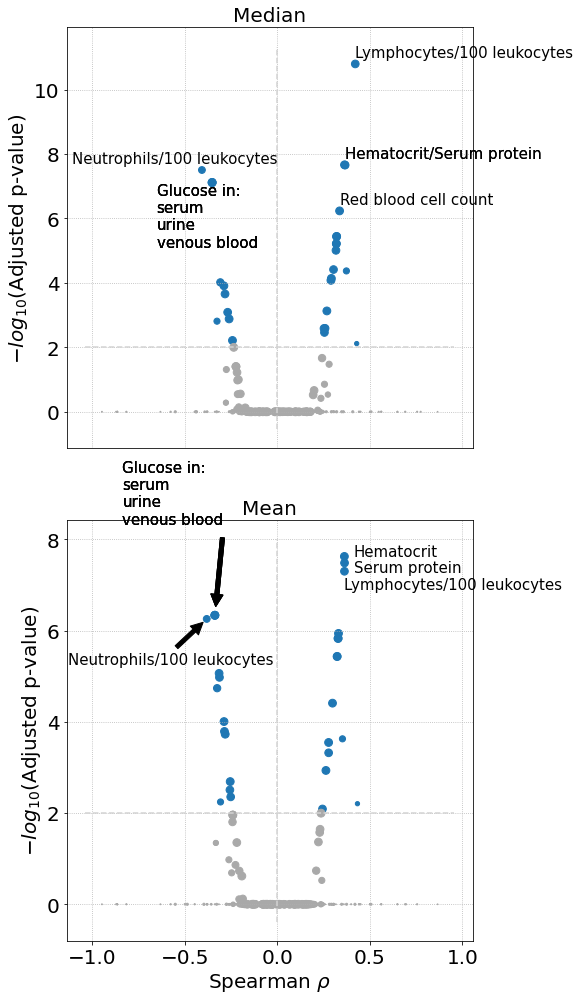

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,14))

# Main plotting lines for median values
ax[0].scatter(results_median_sig['Corr_values_Spearman'],
              results_median_sig['log_bonferroni'],
              marker='o',
              s=results_median_sig['#_cases_given_test']/5)
ax[0].scatter(results_median_nonsig['Corr_values_Spearman'],
              results_median_nonsig['log_bonferroni'],
              marker='o',
              s=results_median_nonsig['#_cases_given_test']/5,
              c='darkgray')

# Various graph-annotating lines for median values
ax[0].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax[0].vlines(0, ax[0].get_ylim()[0],
             ax[0].get_ylim()[-1], color='lightgrey',
             linestyles='dashed')
ax[0].hlines(-1*np.log10(0.01), ax[0].get_xlim()[0],
             ax[0].get_xlim()[-1], color='lightgrey',
             linestyles='dashed')
# ax[0].set_xlabel(r"Spearman $\rho$", fontsize=20)
ax[0].tick_params(bottom=False, labelbottom=False)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Median', fontsize=20)
ax[0].grid(linestyle=':')

# Now annotating specific tests on the median graph
for i in range(0, len(x_median)):
    if x_median[i] < 0:
        if text_median[i] == 'Glucose in:\nserum\nurine\nvenous blood':
            ax[0].annotate(text_median[i],
                           (x_median[i]-0.3, y_median[i]-2),
                           fontsize=15)
        else:
            ax[0].annotate(text_median[i],
                           (x_median[i]-0.7, y_median[i]+0.2),
                           fontsize=15)
    else:
        ax[0].annotate(text_median[i],
                       (x_median[i], y_median[i]+0.2),
                       fontsize=15)

        
# Main plotting lines for mean values
ax[1].scatter(results_mean_sig['Corr_values_Spearman'],
              results_mean_sig['log_bonferroni'],
              marker='o',
              s=results_mean_sig['#_cases_given_test']/5)
ax[1].scatter(results_mean_nonsig['Corr_values_Spearman'],
              results_mean_nonsig['log_bonferroni'],
              marker='o',
              s=results_mean_nonsig['#_cases_given_test']/5,
              c='darkgray')

# Various graph-annotating lines for mean values
ax[1].set_xlabel(r"Spearman $\rho$", fontsize=20)
ax[1].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax[1].vlines(0, ax[1].get_ylim()[0],
             ax[1].get_ylim()[-1], color='lightgrey',
             linestyles='dashed')
ax[1].hlines(-1*np.log10(0.01), ax[1].get_xlim()[0],
             ax[1].get_xlim()[-1], color='lightgrey',
             linestyles='dashed')
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Mean', fontsize=20)
ax[1].grid(linestyle=':')

# Now annotating specific tests on the mean graph
for j in range(0,len(x_mean)):
    if x_mean[j] < 0:
        if text_mean[j] == 'Glucose in:\nserum\nurine\nvenous blood':
            ax[1].annotate(text_mean[j],
                           xy=(x_mean[j], y_mean[j]),
                           xytext=(x_mean[j]-0.5, y_mean[j]+2),
                           fontsize=15,
                           arrowprops=dict(facecolor='black', shrink=0.1))
        else:
            ax[1].annotate(text_mean[j],
                           xy=(x_mean[j], y_mean[j]),
                           xytext=(x_mean[j]-0.75, y_mean[j]-1),
                           fontsize=15,
                           arrowprops=dict(facecolor='black', shrink=0.1))
        
    elif text_mean[j] == 'Lymphocytes/100 leukocytes':
        ax[1].annotate(text_mean[j],
                       (x_mean[j], y_mean[j]-0.4),
                       fontsize=15)
        
    elif text_mean[j] == 'Serum protein':
        ax[1].annotate(text_mean[j],
                       (x_mean[j]+0.05, y_mean[j]-0.2),
                       fontsize=15)
        
    else:
        ax[1].annotate(text_mean[j],
                       (x_mean[j]+0.05, y_mean[j]),
                       fontsize=15)

plt.tight_layout()

Yes! Using the median or the mean to obtain a "typical" value doesn't drastically change which tests associate with the dicharge rank.  
  
  When also looking at the generated results dataframes, I found that many laboratory tests that are used in ICU severity scores (APACHE, SOFA) also appear strongly associated with discharge ranks, which gave me and my group confidence in the validity of the analysis. But this analysis found other tests as well!  
  
  What was surprising to see was both lymphocyte and neutrophil counts on opposite sides of the volcano plots above. When talking about this with clinicians within and outside our lab, their consensus was that while both counts should be expected to go up when a patient has an active infection, they hint at different infectious processes. In general, clinicians pointed to neutrophil counts being better associated with bacterial infections, and lymphocyte counts, to acute viral infections. Since bacterial infections have higher case fatality rates (in general), that might explain the results above. But even as important, things like myocardial infarctions or leukemia can also increase neutrophil counts, which can explain results even further.

## Question 2: Does the presence/absence of a clinical test during a patient's hospitalization predict the patient's discharge favorability?  
EHR is not designed to serve as a research data repository, but rather as a record of clinical-decision making. Because of that, we at the lab thought that clinician suspicions of particular conditions afflicting patients would show in the form of some tests being proxies for severe conditions (and perhaps proxies for milder forms of disease as well). As such, I collected the discharge ranks of patients who received a particular clinical measurement, and the discharge ranks of those who did not receive the measurement. I then used a Mann-Whitney U test to compare the medians of both discharge rank distributions. Alternatively, I also used a method prevalent in gene expression analysis, where I asked which clinical measurements would be enriched in patients who expire vs. those who survive. I did this using Fisher’s exact test of the null hypothesis that observed proportions for both patient groups were identical. Finally, I repeated both analyses for every measurement in the record, and Bonferroni-adjusted due to multiple comparisons. Again, I chose conservative, non-parametric statistical techniques for increased robustness.

In [16]:
# Since we're assessing presence/absence, we can dismiss values
measurements_in_encounter = clean_all_table[['case_number',
                                             'measurement_concept_code',
                                             'measurement_concept_name',
                                             'discharge_disposition_multiple']].drop_duplicates()

Main code block that performs the Mann-Whitney U test analysis

In [17]:
from scipy.stats import mannwhitneyu
agg = []

# Create a pandas series keyed by case_number, returning the specific outcome of that case
outcomes_multiple = clean_all_table[['case_number',
                                     'discharge_disposition_multiple']].drop_duplicates()
outcome_by_patient = outcomes_multiple.set_index('case_number',
                                                 verify_integrity=True)['discharge_disposition_multiple']

# For each measurement in the table
for test in measurements_in_encounter['measurement_concept_name'].unique():
    
    # First, get an array of True/False to flag rows containing the test we'd like to analyze
    k = measurements_in_encounter['measurement_concept_name'] == test
    
    # Now getting the case_numbers (patients) who got the test into a list. This is necessary for later.
    posit_ids = list(measurements_in_encounter.loc[k, 'case_number'])
    
    # Now gather the outcome of each of the patients who got the test
    posit_out = outcome_by_patient[posit_ids]

    # And the outcome of those who didn't get the test
    negat_out = outcome_by_patient[~outcome_by_patient.index.isin(posit_ids)]
    
    # Finally, if at least one patient received, and did not receive the test,
    if len(posit_out) != 0 and len(negat_out) != 0:
        # evaluate Mann-Whitney on both outcome lists
        _, pvaluemw = mannwhitneyu(posit_out,
                                   negat_out,
                                   alternative='two-sided')
    else:
        continue
        
    # And gather results in a row of a table
    result_summary = {'measurement_name': test,
                      'median_present': np.median(posit_out),
                      'median_absent': np.median(negat_out),
                      'p_values_MannWhitney': pvaluemw,
                      'bonferroni_pvalues': np.clip([pvaluemw*measurements_in_encounter['measurement_concept_name'].nunique()],
                                                    0,
                                                    1)[0],
                      'cases_given_test': len(posit_out),
                      'fraction_patients': len(posit_out)/total_cases}
    
    agg.append(result_summary)
    
results_mw = pd.DataFrame(agg)
results_mw['delta_median'] = results_mw['median_present'] - results_mw['median_absent']

Now, let's also see which tests are enriched in patients who expire as a result of their illness (either in the ICU, or sent to hospice care), and which tests are enriched in patients who survive. Using Fisher's exact test, as it is ideal for contingency tables.

In [18]:
# For Fisher's exact test, we needed binary discharges.
outcomes_binary = clean_all_table[['case_number',
                                   'discharge_disposition_binary']].drop_duplicates()

In [19]:
# We need outcomes as boolean variables for Fisher's exact test
outcomes_binary['discharge_disposition_binary'] = outcomes_binary['discharge_disposition_binary'].astype(bool)

# Custom-made function requirement for Fisher's exact test
category_in_annotation = ['survived_in_measurement', 'expired_in_measurement']
category_not_in_annotation = ['survived_not_in_measurement', 'expired_not_in_measurement']

fisher_enrichment = flm_tools.enrichment(outcomes_binary,
                                         clean_all_table,
                                         'case_number',
                                         'discharge_disposition_binary',
                                         'measurement_concept_name',
                                         category_in_annotation,
                                         category_not_in_annotation)

The following are processing steps for plotting. First, processing for Mann-Whitney analysis.

In [20]:
filtered_mw = results_mw.dropna()
filtered_mw.loc[:,'log_bonferroni'] = -1*np.log10(filtered_mw['bonferroni_pvalues'])
filtered_mw_sig = filtered_mw.loc[filtered_mw.bonferroni_pvalues < 0.01]
filtered_mw_nonsig = filtered_mw.loc[filtered_mw.bonferroni_pvalues >= 0.01]

In [21]:
text_mw = ["aPPT in Platelet poor plasma", "Calcium.ionized in Blood",
           "Fibrinogen in Platelet poor plasma", "Burr cells in Blood",
           "Haptoglobin in Serum"]

Next, Fisher's exact test

In [22]:
l = fisher_enrichment['log_bonferroni'] >= 2
l_increase = fisher_enrichment['ratio'] > 0

for m in fisher_enrichment[l].index:
    if fisher_enrichment.loc[m,
                             'measurement_concept_name'] == 'Amikacin [Mass/volume] in Serum or Plasma':
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Amikacin in Serum'
        
    elif fisher_enrichment.loc[m,
                               'measurement_concept_name'] == 'Burr cells [Presence] in Blood by Light microscopy':
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Burr cells in Blood'
        
    else:
        fisher_enrichment.loc[m,
                              'measurement_concept_name'] = 'Fibrinogen in Platelet poor plasma'

Plotting!

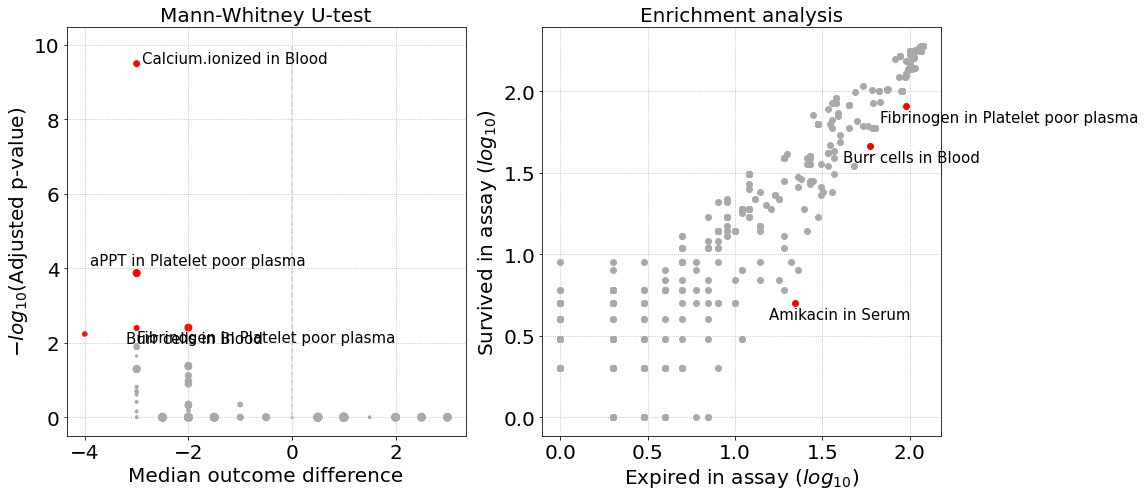

In [23]:
fig1,ax1 = plt.subplots(ncols=2, nrows=1, figsize=(16,7))

# Main plotting lines for Mann-Whitney
ax1[0].scatter(filtered_mw_sig['delta_median'],
               filtered_mw_sig['log_bonferroni'],
               marker='o',
               s=filtered_mw_sig['cases_given_test']/5,
               c='r')
ax1[0].scatter(filtered_mw_nonsig['delta_median'],
               filtered_mw_nonsig['log_bonferroni'],
               marker='o',
               s=filtered_mw_nonsig['cases_given_test']/5,
               c='darkgray')

# Various graph-annotating lines for Mann-Whitney
ax1[0].set_xlabel("Median outcome difference", fontsize=20)
ax1[0].set_ylabel(r"$-log_{10}$(Adjusted p-value)", fontsize=20)
ax1[0].tick_params(axis='x', labelsize=20)
ax1[0].tick_params(axis='y', labelsize=20)
ax1[0].vlines(0, 0, ax1[0].get_ylim()[-1],
              color='lightgrey', linestyles='dashed')
ax1[0].grid(linestyle=':')
ax1[0].set_title('Mann-Whitney U-test', fontsize=20)

# Now annotating specific tests on the Mann-Whitney graph
x = list(filtered_mw_sig['delta_median'])
y = list(filtered_mw_sig['log_bonferroni'])

for n in range(0,len(x)):
    if text_mw[n] == "Fibrinogen in Platelet poor plasma":
        ax1[0].annotate(text_mw[n],
                        (x[n]-1, y[n]-0.4),
                        fontsize=15)
        
    elif text_mw[n] == "Calcium.ionized in Blood":
        ax1[0].annotate(text_mw[n],
                        (x[n]+0.1, y[n]),
                        fontsize=15)
        
    elif text_mw[n] == "Haptoglobin in Serum":
        ax1[0].annotate(text_mw[n],
                        (x[n]-1.3, y[n]+0.4),
                        fontsize=15)
        
    elif text_mw[n] == "Burr cells in Blood":
        ax1[0].annotate(text_mw[n],
                        (x[n]-0.2, y[n]-0.4),
                        fontsize=15)
        
    else:
        ax1[0].annotate(text_mw[n],
                        (x[n]-0.9, y[n]+0.2),
                        fontsize=15)

        
# Main plotting lines for Fisher's exact test
ax1[1].scatter(np.log10(fisher_enrichment.loc[~l,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[~l,
                                              'survived_in_measurement'] + 1),
               c='darkgray')
ax1[1].scatter(np.log10(fisher_enrichment.loc[l & l_increase,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[l & l_increase,
                                              'survived_in_measurement'] + 1),
               c='blue')
ax1[1].scatter(np.log10(fisher_enrichment.loc[l & ~l_increase,
                                              'expired_in_measurement'] + 1),
               np.log10(fisher_enrichment.loc[l & ~l_increase,
                                              'survived_in_measurement'] + 1),
               c='r')

# Now annotating specific tests on the Fisher's exact test's graph
for o in fisher_enrichment[l].index:
    ax1[1].text(np.log10(fisher_enrichment.loc[o,
                                               'expired_in_measurement'] + 1) - 0.15,
                np.log10(fisher_enrichment.loc[o,
                                               'survived_in_measurement'] + 1) - 0.1,
                fisher_enrichment.loc[o,
                                      'measurement_concept_name'],
                fontsize=15)
    
# Various graph-annotating lines for Fisher's exact test
ax1[1].set_xlabel(r"Expired in assay ($log_{10}$)", fontsize=20)
ax1[1].set_ylabel(r"Survived in assay ($log_{10}$)", fontsize=20)
ax1[1].tick_params(axis='x', labelsize=20)
ax1[1].tick_params(axis='y', labelsize=20)
ax1[1].grid(linestyle=':')
ax1[1].set_title('Enrichment analysis', fontsize=20)

plt.tight_layout()

These are interesting! For the Mann-Whitney plot, the red dots are specific clinical measurements for which patients who had them in their hospitalization record generally fared worse than those who didn't get those measurements. And for the Fisher's exact test plot, those red dots signify measurements that are significantly prevalent among patients who expire.  

Talking to clinicians, I learned that these clinical measurements are indeed indicators of poor clinical courses. In general, they seem to point to patients who were being tested for coagulopathies, or blood-clotting disorders. These disorders are life-threatening complications of infectious diseases, and patients with a blood malignancy or liver condition would be more susceptible to coagulopathies.  

Even more interesting is the presence of amikacin. This is a "last-resort" antibiotic, but the fact that it gets measured implies that clinicians were assessing dosage. Another measurement used in monitoring is ionized calcium in blood, which is used to assess calcium homeostasis in patients with terminal kidney failure who are subjected to continuous renal replacement (CRRT).  

Now, the presence of Burr cell testing is puzzling. Clinicians assess abnormalities in blood cells through a complete blood count (CBC), and Burr cell testing generally doesn't get reported as part of this panel. UNLESS the lab is certain of having found Burr cells (which can get confused with red blood cells if blood smear is done improperly). However, if they are indeed present, they are a clear sign of uremia (a terminal kidney failure condition).  

Therefore, these clinical measurements are very indicative of poor clinical courses just by the mere fact that they are present.

## Cool, are we done here?

OF COURSE NOT!  
  
  One thing I noticed from displaying result tables for the above analyses is that most of these measurements appear in a majority of patient records (except for significantly associated measurements in analysis of presence/absence; they would probably hover around being present in half of the patient cohort).

In [24]:
results_median_sig.sort_values(by='log_bonferroni', ascending=False).head()

,measurement_name,Corr_values_Spearman,P_values_Spearman,Bonferroni_pvalue,#_cases_given_test,%_cases_given_test,log_bonferroni
102,Lymphocytes/100 leukocytes in Blood by Automat...,0.420979,4.668487e-14,1.596623e-11,294,95.765472,10.796798
72,Hematocrit [Volume Fraction] of Blood by Autom...,0.362889,6.331570e-11,2.165397e-08,305,99.348534,7.664462
48,Protein [Mass/volume] in Serum or Plasma,0.366154,6.439807e-11,2.202414e-08,299,97.394137,7.657101
111,Neutrophils/100 leukocytes in Blood by Automat...,-0.408102,9.157333e-11,3.131808e-08,233,75.895765,7.504205
36,Glucose [Mass/volume] in Serum or Plasma,-0.352941,2.240897e-10,7.663866e-08,305,99.348534,7.115552


In [25]:
filtered_mw_sig

,measurement_name,median_present,median_absent,p_values_MannWhitney,bonferroni_pvalues,cases_given_test,fraction_patients,delta_median,log_bonferroni
116,aPTT in Platelet poor plasma by Coagulation assay,2.0,5.0,2.475843e-07,1.339431e-04,246,0.801303,-3.0,3.873080
117,Fibrinogen [Mass/volume] in Platelet poor plas...,1.0,4.0,5.863629e-13,3.172223e-10,175,0.570033,-3.0,9.498636
119,Calcium.ionized [Moles/volume] in Blood,2.0,4.0,7.237130e-06,3.915287e-03,238,0.775244,-2.0,2.407236
165,Haptoglobin [Mass/volume] in Serum or Plasma,1.0,4.0,7.406998e-06,4.007186e-03,119,0.387622,-3.0,2.397160
195,Burr cells [Presence] in Blood by Light micros...,0.0,4.0,1.073651e-05,5.808454e-03,103,0.335505,-4.0,2.235939


As it should be. Otherwise previous findings would be spurious.  
But I wondered how the distribution of patients/cases given test would look like.

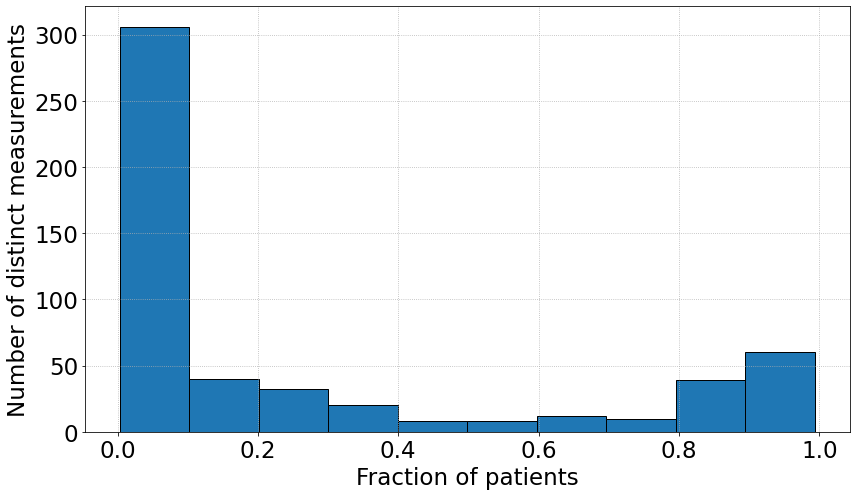

In [26]:
fig2, ax2 = plt.subplots(1,1,figsize=(12,7))
ax2.hist(results_mw['fraction_patients'], bins=10, edgecolor='k')
ax2.set_xlabel('Fraction of patients',fontsize=23)
ax2.set_ylabel('Number of distinct measurements',fontsize=23)
ax2.tick_params(axis='x', labelsize=23)
ax2.tick_params(axis='y', labelsize=23)
ax2.grid(linestyle=':')
plt.tight_layout()

This isn't too surprising: There will be a core battery of clinical measurements representing vital signs (heart rate, temperature, etc.), and then some labs that are meant to be taken daily.  
But I cannot ignore that ~300 out of 541 clinical measurements only appear in 10% or less of the patients in the cohort.  
What are these measurements?

In [27]:
# Wrangling the pandas dataframe containing the data to get counts
measurement_pt_counts = clean_all_table.copy()
measurement_pt_counts['value_as_number'] = 1
measurement_pt_counts = measurement_pt_counts[['case_number',
                                               'measurement_concept_name',
                                               'value_as_number']].drop_duplicates()

measurement_pt_counts = measurement_pt_counts.pivot(index='measurement_concept_name',
                                                    columns='case_number',
                                                    values='value_as_number').reset_index()

measurement_pt_counts = measurement_pt_counts.set_index('measurement_concept_name').fillna(0).astype(float)
total_patients = len(measurement_pt_counts.columns)
measurement_pt_counts['number_of_patients'] = measurement_pt_counts.sum(axis=1)
measurement_pt_counts['fraction_patients'] = measurement_pt_counts['number_of_patients']/total_patients
measurement_pt_counts = measurement_pt_counts.reset_index()
measurement_pt_counts = measurement_pt_counts[['measurement_concept_name',
                                               'number_of_patients',
                                               'fraction_patients']]

p = measurement_pt_counts['fraction_patients'] < 0.1
measurement_pt_counts.loc[p].sort_values(by='fraction_patients')

case_number,measurement_concept_name,number_of_patients,fraction_patients
540,von Willebrand factor (vWf).activity actual/no...,1.0,0.003257
50,Band form neutrophils/100 leukocytes in Blood ...,1.0,0.003257
51,Band form neutrophils/100 leukocytes in Cerebr...,1.0,0.003257
394,Phosphate [Mass/volume] in Urine,1.0,0.003257
390,Phenytoin [Mass/volume] in Serum or Plasma,1.0,0.003257
...,...,...,...
26,Alpha 1 globulin [Mass/volume] in Serum or Pla...,29.0,0.094463
206,Gamma globulin [Mass/volume] in Serum or Plasm...,29.0,0.094463
17,Albumin/Globulin [Mass Ratio] in Serum or Plas...,29.0,0.094463
65,Beta-2-Microglobulin [Mass/volume] in Serum or...,29.0,0.094463


Brief research into these measurements:  
-Bone myelin basic protein concentration in cerebrospinal fluid: Used to assess demyelination, which among many causes, could be due to traumatic brain injury.  
-Thyroglobulin serum concentration: Used to monitor thyroid cancer treatment.  
-Carcinoembryonic antigen serum concentration: Used to monitor treatment of various carcinomas.  
  
  Then, when talking again with clinicians, they had the impression that many of these measurements were indicators of very odd clinical pictures. If a clinician orders some of these, it might suggest desperate search attempts for a diagnosis.  
  
  So, these "rarely" given measurements do contain information about the clinical course of a patient. But how to assess that if these measurements aren't prevalent in the cohort (by definition)? It was at this point that I thought of switching the approach, since statistical tools applied on the data as is would not help in revealing all possibly informative measurements.  
  
  However, there was a simple way to assess whether these rarely given tests would associate with outcomes.

## Question 3: Which patients disproportionately get "rarely" given tests?  
For this question, I counted how many times in total these "rarely" given measurements (which I defined as those appearing in <10% of the cohort) appear in the dataset (~8000 times). And out of those times, how many are done to expired, transferred, or sent home patients (this was another way to group discharges, which was suggested to me by a clinician labmate). I assessed the statistical significance of these fractions by bootstrapping them to generate 99% confidence intervals, and compared them to the baseline cohort fraction of each discharge category (expired: 38% of cohort, transferred: 36% of cohort, sent home: 26% of cohort). To ensure that patterns I saw were consistent, I also evaluated these fractions on a daily basis.

In [28]:
# Since I'll encode discharges differently
outcomes_three = clean_all_table[['case_number',
                                  'discharge_disposition_three']].drop_duplicates()

In [29]:
# Slicing main dataframe to get measurements appearing in <10% of cohort
rare_measurements = measurement_pt_counts.loc[p, 'measurement_concept_name']
q = clean_all_table['measurement_concept_name'].isin(rare_measurements)
cut_all_table = clean_all_table.loc[q].copy()
cut_all_table['value_as_number'] = 1

In [30]:
# Generating bootstrapped counts of the number of times rare measurements appear
# in expired, transferred, and sent home patients/cases
expired_mask = cut_all_table['discharge_disposition_three'] == 0
transferred_mask = cut_all_table['discharge_disposition_three'] == 1
home_mask = cut_all_table['discharge_disposition_three'] == 2

# Converting boolean array to int
rare_given_expired = list(expired_mask.astype(int))
boot_rare_expired = np.random.choice(rare_given_expired,
                                     size=(10000,len(rare_given_expired)),
                                     replace=True)

rare_given_transferred = list(transferred_mask.astype(int))
boot_rare_transferred = np.random.choice(rare_given_transferred,
                                         size=(10000,len(rare_given_transferred)),
                                         replace=True)

rare_given_home = list(home_mask.astype(int))
boot_rare_home = np.random.choice(rare_given_home,
                                  size=(10000,len(rare_given_home)),
                                  replace=True)

In [31]:
# Collecting results for plotting
expired_means = np.mean(boot_rare_expired,axis=1)
transferred_means = np.mean(boot_rare_transferred,axis=1)
home_means = np.mean(boot_rare_home,axis=1)

# Expired df
agg = []
for i in range(len(expired_means)):
    temp = {"Outcome": 'Expired',
            "Fractions": expired_means[i]}
    agg.append(temp)
    
expired_df = pd.DataFrame(agg)

# Transferred df
agg = []
for i in range(len(transferred_means)):
    temp = {"Outcome": 'Transferred',
            "Fractions": transferred_means[i]}
    agg.append(temp)
    
transferred_df = pd.DataFrame(agg)

# Sent Home df
agg = []
for i in range(len(home_means)):
    temp = {"Outcome": 'Sent Home',
            "Fractions": home_means[i]}
    agg.append(temp)
    
home_df = pd.DataFrame(agg)

# Collecting them all
rare_fractions = pd.concat([expired_df, transferred_df, home_df])

In [32]:
# Getting fractions of cohort from each discharge category
s = outcomes_three['discharge_disposition_three'].value_counts()
count = s.values
result = s.index

df_three = pd.DataFrame({"outcome": result, "counts": count, "fraction": count/count.sum()})
df_three = df_three.replace({0: "Expired", 1: "Transferred", 2: "Sent Home"})
df_three

,outcome,counts,fraction
0,Expired,118,0.384365
1,Transferred,110,0.358306
2,Sent Home,79,0.257329


Now, analyzing the same pattern, but on a daily basis instead of a composite of the entire hospital stay.

In [33]:
# Will show data for up to the median length of stay
# of sent home patients (9 days, the rest are 15 and 16 days)
r = clean_all_table['discharge_disposition_three'] == 2
home = clean_all_table[r]
LOS = int(np.median(home['day_of_visit'])) + 1

In [34]:
# Now, setting up the numpy arrays for the following loop
rare_fraction_expired = np.zeros((LOS,3))
rare_fraction_transferred = np.zeros((LOS,3))
rare_fraction_home = np.zeros((LOS,3))

# The loop essentially repeats the above analysis for each day
for day in range(1, LOS):
    # This gives the rare test record at each day
    t = cut_all_table['day_of_visit'] == day
    rare_given_in_day = cut_all_table.loc[t]
    
    expired_mask = rare_given_in_day['discharge_disposition_three'] == 0
    transferred_mask = rare_given_in_day['discharge_disposition_three'] == 1
    home_mask = rare_given_in_day['discharge_disposition_three'] == 2
    
    rare_given_expired = list(expired_mask.astype(int))
    boot_rare_expired = np.random.choice(rare_given_expired,
                                         size=(10000, len(rare_given_expired)),
                                         replace=True)
    
    rare_given_transferred = list(transferred_mask.astype(int))
    boot_rare_transferred = np.random.choice(rare_given_transferred,
                                             size=(10000, len(rare_given_transferred)),
                                             replace=True)
    
    rare_given_home = list(home_mask.astype(int))
    boot_rare_home = np.random.choice(rare_given_home,
                                      size=(10000, len(rare_given_home)),
                                      replace=True)
    
    rare_fraction_expired[day-1,:] = [np.mean(np.mean(boot_rare_expired, axis=1)),
                                      np.percentile(np.mean(boot_rare_expired, axis=1), 0.5),
                                      np.percentile(np.mean(boot_rare_expired, axis=1), 99.5)]
    
    rare_fraction_transferred[day-1,:] = [np.mean(np.mean(boot_rare_transferred, axis=1)),
                                          np.percentile(np.mean(boot_rare_transferred, axis=1), 0.5),
                                          np.percentile(np.mean(boot_rare_transferred, axis=1), 99.5)]
    
    rare_fraction_home[day-1,:] = [np.mean(np.mean(boot_rare_home, axis=1)),
                                   np.percentile(np.mean(boot_rare_home, axis=1), 0.5),
                                   np.percentile(np.mean(boot_rare_home, axis=1), 99.5)]

At last, the figures!

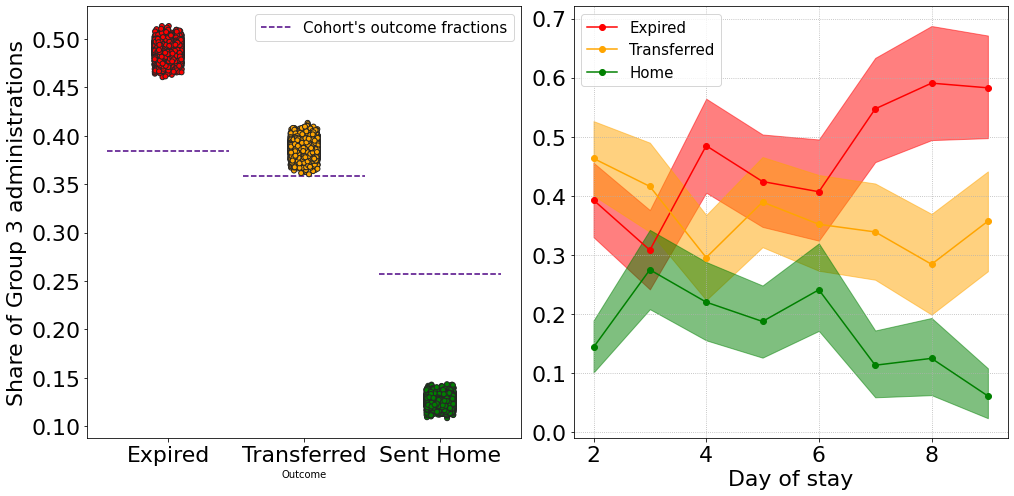

In [35]:
labels = ['Expired', 'Transferred', 'Sent home']
x = np.arange(len(labels))

fig3, ax3 = plt.subplots(ncols=2, nrows=1, figsize=(14,7))

# Main plotting line for first graph
sns.stripplot(x='Outcome', y='Fractions', data=rare_fractions, ax=ax3[0],
              linewidth=1, palette=['r','orange','g'])

# Annotating the baseline cohort fractions
ax3[0].hlines(df_three.loc[df_three['outcome'] == 'Expired', 'fraction'],
              x[0] - 0.45, x[0] + 0.45, color='indigo',
              linestyles='dashed', label="Cohort's outcome fractions")
ax3[0].hlines(df_three.loc[df_three['outcome'] == 'Transferred', 'fraction'],
              x[1] - 0.45, x[1] + 0.45, color='indigo',
              linestyles='dashed')
ax3[0].hlines(df_three.loc[df_three['outcome'] == 'Sent Home', 'fraction'],
              x[2] - 0.45, x[2] + 0.45, color='indigo',
              linestyles='dashed')

# Beautifying plot 1
ax3[0].tick_params(axis='x', labelsize=22)
ax3[0].tick_params(axis='y', labelsize=22)
ax3[0].set_ylabel('Share of Group 3 administrations', size=22)
ax3[0].legend(loc='best', fontsize=15)


# Main plotting lines for graph 2
# Chose to plot from day 2 onwards as day 1 contains patients enrolled
# At different hours during such day (not the full 24 hours)
ax3[1].plot(list(range(2, LOS)), rare_fraction_expired[:,0][1:LOS-1],
            marker='o', color='red', label='Expired')

# For plotting the 99% CIs
ax3[1].fill_between(list(range(2, LOS)), rare_fraction_expired[:,1][1:LOS-1],
                    rare_fraction_expired[:,2][1:LOS-1], color='red', alpha=0.5)

ax3[1].plot(list(range(2, LOS)), rare_fraction_transferred[:,0][1:LOS-1],
            marker='o', color='orange', label='Transferred')
ax3[1].fill_between(list(range(2, LOS)), rare_fraction_transferred[:,1][1:LOS-1],
                    rare_fraction_transferred[:,2][1:LOS-1], color='orange', alpha=0.5)

ax3[1].plot(list(range(2, LOS)), rare_fraction_home[:,0][1:LOS-1],
            marker='o', color='green', label='Home')
ax3[1].fill_between(list(range(2, LOS)), rare_fraction_home[:,1][1:LOS-1],
                    rare_fraction_home[:,2][1:LOS-1], color='green', alpha=0.5)

# Annotating graph 2
ax3[1].tick_params(axis='x', labelsize=22)
ax3[1].tick_params(axis='y', labelsize=22)
ax3[1].set_xlabel('Day of stay', size=22)
ax3[1].legend(loc='upper left', fontsize=15)
ax3[1].grid(linestyle=':')

plt.tight_layout()

The above plots show very clearly that these rarely given tests are administered disproportionally to patients who expire, and that this pattern largely holds on a day to day basis.  
I expected this if these tests are indeed suggestive of complicated pre-existing conditions, which would also explain why these patients are more likely to expire.  
And then, contrast those results with the proportion of rare tests given to patients sent home. While representing ~25% of the cohort, they account for ~12% of the administrations of rare tests.  
It would have been interesting to see which tests among these account for most administrations. While the above analysis was done on all 306 rare tests as a group, it might be the case that just a handful of tests drive the counts.

## Conclusion

Through the above analyses, I could claim to have reduced the number of important clinical measurements (or features) from 541 to a short-list of ~40, based on which measurements showed robust correlations with discharge favorabilities (either from the typical numeric value, or through their presence/absence).  
But measurements that are not frequently given so obviously indicated complicated clinical pictures that I can't turn a blind eye to them simply because they aren't amenable to brute-force statistical techniques.  
Now, if we were to build a model attempting to characterize daily patient states, we would be greatly served by measurements that showed strong signal from the above analyses, and also happen to be frequent enough. But rare tests showed that they contain important "baseline" information on patients.  
  
  The question was: How to capture that?

# P.S.

*I explored the possibility of understanding these clinical measurements as indicators of physiological variables. In that way, one could exploit the fact that many measurements try to assess the same physiological variable with either different lab techniques, or different samples. This is the subject of masterthesis02.*  
<img src = '../src/measurements to HPO.png'></img>